In [ ]:
# Bibliotecas Gerais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Model definition with regularization, batch normalization, and dropout
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
# Optionally, you can plot the training history
import matplotlib.pyplot as plt
# TensorFlow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [4]:
# Load data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')


In [ ]:
## CODIGO DE TESTE ##


# Função para dividir o nome do arquivo e extrair informações
def extract_features_from_filename(filename):
    parts = filename.split('_')

    def clean_coordinate(coordinate):
        """Remove hyphens and convert to float if possible."""
        clean_coord = coordinate.replace('-', '')
        try:
            return float(clean_coord)
        except ValueError:
            return clean_coord

    #print(parts)

    if len(parts) == 11:
        coordinates_id1 = clean_coordinate(parts[4])
        coordinates_id2 = clean_coordinate(parts[5])
        date_time_acquisition_start = parts[8].replace('T', '')
        date_time_acquisition_end = parts[9].replace('T', '')
        return pd.Series([coordinates_id1, coordinates_id2, date_time_acquisition_start, date_time_acquisition_end], 
                         index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

    if len(parts) == 10:
        coordinates_id1 = clean_coordinate(parts[3])
        coordinates_id2 = clean_coordinate(parts[4])
        date_time_acquisition_start = parts[7].replace('T', '')
        date_time_acquisition_end = parts[8].replace('T', '')
        return pd.Series([coordinates_id1, coordinates_id2, date_time_acquisition_start, date_time_acquisition_end], 
                         index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

    if len(parts) == 9:
        coordinates_id1 = clean_coordinate(parts[2])
        coordinates_id2 = clean_coordinate(parts[3])
        date_time_acquisition_start = parts[6].replace('T', '')
        date_time_acquisition_end = parts[7].replace('T', '')
        return pd.Series([coordinates_id1, coordinates_id2, date_time_acquisition_start, date_time_acquisition_end], 
                         index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

    if len(parts) == 8:
        coordinates_id1 = clean_coordinate(parts[1])
        coordinates_id2 = clean_coordinate(parts[2])
        date_time_acquisition_start = parts[5].replace('T', '')
        date_time_acquisition_end = parts[6].replace('T', '')
        return pd.Series([coordinates_id1, coordinates_id2, date_time_acquisition_start, date_time_acquisition_end], 
                         index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

    return pd.Series([None]*4, index=['coordinates_id1', 'coordinates_id2', 'date_time_acquisition_start', 'date_time_acquisition_end'])

# Aplicar a função a cada nome de arquivo no dataset
file_features = train_data['file_name_l1'].apply(extract_features_from_filename)
file_features_test = test_data['file_name_l1'].apply(extract_features_from_filename)

## CODIGO DE TESTE ##

# Concatenar as novas features ao dataframe original

#train_data = pd.concat([train_data, file_features], axis=1)
#test_data = pd.concat([test_data, file_features_test], axis=1)


In [5]:

# Remove columns 'id' and 'file_name_l1'
train_data = train_data.drop(columns=['id', 'file_name_l1'])
test_data = test_data.drop(columns=['file_name_l1'])

In [ ]:

# Estatísticas descritivas
print("Estatísticas Descritivas do Dataset COMPLETO de Treino:")
print(train_data.describe())


print("\n")
# Verificar valores nulos
print("Verificar Missing Data:")
print(train_data.isnull().sum())

In [ ]:
# Graficos e Visualizações

#Visualizar a distribuição normal das features
df_analise_dist = train_data.melt()

#Criar um FaceGrit com um histograma para cada feature do DataSet
g = sns.FacetGrid(df_analise_dist, col="variable", col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.histplot, "value", kde=False, color='blue', bins=30)
plt.show()


#Visualizar a distribuição de outliers
df_analise_box_plot = train_data.melt()

#FaceGrit com os box Plot
g = sns.FacetGrid(df_analise_box_plot, col="variable", col_wrap=4, sharex=False, sharey=False, height=4)
g.map(sns.boxplot, "value")
plt.show()
        

# Visualizações (dependendo do tipo de dados, ajuste as visualizações)
sns.pairplot(train_data)
plt.show()

In [6]:
# Train and Validation Set
X = train_data.drop(columns=['value_550'])
y = train_data['value_550']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)


# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [7]:

def create_model():
    model = Sequential([
        Dense(1280, activation='relu', kernel_regularizer=l2(0.0001), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(640, activation='relu', kernel_regularizer=l2(0.001)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(320, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(1)  # Output layer for regression
    ])

    # Compile the model with a lower learning rate
    optimizer = Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

# Define the KFold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=10)

# Store validation results
val_mae_scores = []

for train_index, val_index in kf.split(X_train_scaled):
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    # Create a new model instance
    model = create_model()

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=[early_stopping], verbose=1)

    # Print model summary
    model.summary()

    # Evaluate the model on the validation set
    val_loss, val_mae = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_mae_scores.append(val_mae)
    print(f"Fold Validation MAE: {val_mae}")

# Calculate the mean and standard deviation of the validation MAE scores
mean_val_mae = np.mean(val_mae_scores)
std_val_mae = np.std(val_mae_scores)

print(f"\nMean Validation MAE: {mean_val_mae}")
print(f"Standard Deviation of Validation MAE: {std_val_mae}")


Epoch 1/30


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.3182 - mae: 1.1568 - val_loss: 5.0529 - val_mae: 0.2463
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 6.0973 - mae: 0.8547 - val_loss: 4.8923 - val_mae: 0.2043
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.7716 - mae: 0.7787 - val_loss: 4.7950 - val_mae: 0.2933
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.4360 - mae: 0.7057 - val_loss: 4.6366 - val_mae: 0.2603
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.2331 - mae: 0.6765 - val_loss: 4.4874 - val_mae: 0.2423
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.9916 - mae: 0.6217 - val_loss: 4.3263 - val_mae: 0.2190
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.7893 - mae: 0.5916 - val_loss: 4.1745 - val_mae: 0.2103
Epoch 8/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.5579 - mae: 0.5441 - val_loss: 4.0531 - val_mae: 0.2140
Epoch 9/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.4116 

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1280)           │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 640)            │       819,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 640)            │         2,560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 320)            │       205,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,124,485 (11.92 MB)

 Trainable params: 1,040,001 (3.97 MB)

 Non-trainable params: 4,480 (17.50 KB)

 Optimizer params: 2,080,004 (7.93 MB)

Fold Validation MAE: 0.09045692533254623
Epoch 1/30


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6.9264 - mae: 1.0651 - val_loss: 4.9835 - val_mae: 0.1977
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.9746 - mae: 0.8084 - val_loss: 4.8219 - val_mae: 0.2250
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.5089 - mae: 0.7037 - val_loss: 4.6583 - val_mae: 0.2101
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.2528 - mae: 0.6562 - val_loss: 4.5091 - val_mae: 0.2264
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.0206 - mae: 0.6199 - val_loss: 4.3326 - val_mae: 0.1905
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.7857 - mae: 0.5804 - val_loss: 4.1795 - val_mae: 0.1804
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.5851 - mae: 0.5532 - val_loss: 4.0240 - val_mae: 0.1649
Epoch 8/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.3689 - mae: 0.5065 - val_loss: 3.8748 - val_mae: 0.1527
Epoch 9/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.1864

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1280)           │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 640)            │       819,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 640)            │         2,560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 320)            │       205,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,124,485 (11.92 MB)

 Trainable params: 1,040,001 (3.97 MB)

 Non-trainable params: 4,480 (17.50 KB)

 Optimizer params: 2,080,004 (7.93 MB)

Fold Validation MAE: 0.09814786911010742
Epoch 1/30


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 7.1170 - mae: 1.1164 - val_loss: 5.0737 - val_mae: 0.2508
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.0309 - mae: 0.8300 - val_loss: 5.0876 - val_mae: 0.4448
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.6268 - mae: 0.7446 - val_loss: 5.0080 - val_mae: 0.5806
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.2844 - mae: 0.6697 - val_loss: 4.7453 - val_mae: 0.4525
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.0649 - mae: 0.6318 - val_loss: 4.5490 - val_mae: 0.4351
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.8455 - mae: 0.5987 - val_loss: 4.3562 - val_mae: 0.3627
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.6452 - mae: 0.5704 - val_loss: 4.1910 - val_mae: 0.3793
Epoch 8/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.4260 - mae: 0.5299 - val_loss: 4.0135 - val_mae: 0.3419
Epoch 9/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.2348 

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 1280)           │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 640)            │       819,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 640)            │         2,560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 320)            │       205,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,124,485 (11.92 MB)

 Trainable params: 1,040,001 (3.97 MB)

 Non-trainable params: 4,480 (17.50 KB)

 Optimizer params: 2,080,004 (7.93 MB)

Fold Validation MAE: 0.08434180170297623
Epoch 1/30


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.1854 - mae: 1.1376 - val_loss: 5.0989 - val_mae: 0.3070
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 6.1766 - mae: 0.8742 - val_loss: 4.9675 - val_mae: 0.2917
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.7226 - mae: 0.7583 - val_loss: 4.8405 - val_mae: 0.3167
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.4547 - mae: 0.6980 - val_loss: 4.6735 - val_mae: 0.2835
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.1972 - mae: 0.6515 - val_loss: 4.5593 - val_mae: 0.3109
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.9843 - mae: 0.6172 - val_loss: 4.3968 - val_mae: 0.3053
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.8005 - mae: 0.5916 - val_loss: 4.2520 - val_mae: 0.2753
Epoch 8/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.5702 - mae: 0.5430 - val_loss: 4.1115 - val_mae: 0.2763
Epoch 9/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4.3925 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 1280)           │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 640)            │       819,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 640)            │         2,560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 320)            │       205,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,124,485 (11.92 MB)

 Trainable params: 1,040,001 (3.97 MB)

 Non-trainable params: 4,480 (17.50 KB)

 Optimizer params: 2,080,004 (7.93 MB)

Fold Validation MAE: 0.08325308561325073
Epoch 1/30


C:\Users\Jojo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


209/209 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 7.0050 - mae: 1.0658 - val_loss: 5.0964 - val_mae: 0.3276
Epoch 2/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5.9748 - mae: 0.8061 - val_loss: 4.9930 - val_mae: 0.3884
Epoch 3/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.6077 - mae: 0.7242 - val_loss: 4.8213 - val_mae: 0.3700
Epoch 4/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.3084 - mae: 0.6562 - val_loss: 4.6695 - val_mae: 0.3649
Epoch 5/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 5.0987 - mae: 0.6341 - val_loss: 4.4888 - val_mae: 0.3498
Epoch 6/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.8776 - mae: 0.6002 - val_loss: 4.3049 - val_mae: 0.3136
Epoch 7/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.6321 - mae: 0.5557 - val_loss: 4.1326 - val_mae: 0.2788
Epoch 8/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.4317 - mae: 0.5237 - val_loss: 3.9520 - val_mae: 0.2363
Epoch 9/30
209/209 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 4.2303 

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 1280)           │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 640)            │       819,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 640)            │         2,560 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 320)            │       205,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 320)            │         1,280 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           321 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,124,485 (11.92 MB)

 Trainable params: 1,040,001 (3.97 MB)

 Non-trainable params: 4,480 (17.50 KB)

 Optimizer params: 2,080,004 (7.93 MB)

Fold Validation MAE: 0.08041608333587646

Mean Validation MAE: 0.08732315301895141
Standard Deviation of Validation MAE: 0.006327029687470296


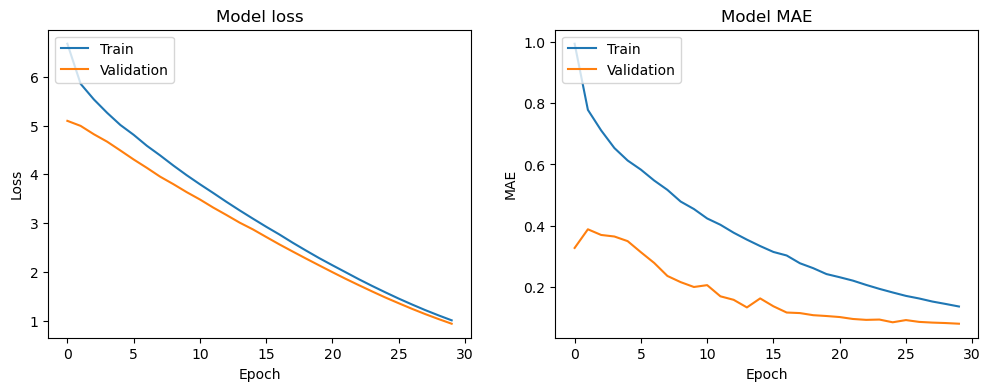

In [8]:
# Plot training & validation loss values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [9]:
# Standardize the test data using the same scaler fitted on the training data
test_data_scaled = scaler.transform(test_data.drop(columns=['id']))


In [10]:
# Generate predictions on the test data
predictions = model.predict(test_data_scaled)

# Prepare the submission DataFrame
submission = pd.DataFrame({
    'id': test_data['id'],
    'value_550': predictions.flatten()  # Flatten in case predictions are not a 1D array
})

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file created successfully!")


85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Submission file created successfully!


In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np


## CODIGO DE TESTE ##

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the function to create your Keras model
def create_model(optimizer='adam', 
                 kernel_regularizer_1=0.0001, 
                 kernel_regularizer_2=0.001, 
                 kernel_regularizer_3=0.01, 
                 dropout_rate_1=0.5, 
                 dropout_rate_2=0.5, 
                 dropout_rate_3=0.2):
    model = Sequential([
        Dense(1280, activation='relu', kernel_regularizer=l2(kernel_regularizer_1), input_shape=(X_scaled.shape[1],)),
        BatchNormalization(),
        Dropout(dropout_rate_1),
        Dense(640, activation='relu', kernel_regularizer=l2(kernel_regularizer_2)),
        BatchNormalization(),
        Dropout(dropout_rate_2),
        Dense(320, activation='relu', kernel_regularizer=l2(kernel_regularizer_3)),
        BatchNormalization(),
        Dropout(dropout_rate_3),
        Dense(1)  # Output layer for regression
    ])
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

# Create a KerasRegressor based on your Keras model
model = KerasRegressor(model=create_model, epochs=300, batch_size=32, verbose=0)

# Define the grid search parameters with correct prefixes
param_grid = {
    'model__optimizer': ['adam', 'sgd'],
    'model__kernel_regularizer_1': [0.0001, 0.001, 0.01],
    'model__kernel_regularizer_2': [0.0001, 0.001, 0.01],
    'model__kernel_regularizer_3': [0.0001, 0.001, 0.01],
    'model__dropout_rate_1': [0.3, 0.5, 0.7],
    'model__dropout_rate_2': [0.3, 0.5, 0.7],
    'model__dropout_rate_3': [0.2, 0.4, 0.6]
}

# Create GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)

# Fit GridSearchCV
grid_result = grid_search.fit(X_scaled, y)

# Summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
